# Notebook predykcyjny dla ceny Bitcoina z rozszerzoną analizą i wizualizacją krzywych uczenia

W tym notatniku przeprowadzimy kompleksową analizę szeregu czasowego cen Bitcoina oraz zbudujemy i ocenimy model LSTM do prognozowania przyszłych wartości. Obejmujemy eksplorację danych, analizę statystyczną, dekompozycję sezonowości, przygotowanie danych, budowę i trenowanie modelu, ewaluację oraz wizualizację wyników.

## Importowanie bibliotek i ustawienia

Zaimportuj wszystkie niezbędne biblioteki do analizy danych, wizualizacji, budowy i trenowania modelu LSTM. Ustaw losowość dla powtarzalności wyników.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import yfinance as yf

import random
import os

from sklearn.model_selection import train_test_split

# Ustawienia powtarzalności
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Ustawienia wykresów
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

## Pobieranie i eksploracja danych o cenach Bitcoina

Pobierz dane historyczne Bitcoina (ticker `BTC-USD`) z Yahoo Finance. Wyświetl podstawowe informacje, zakres dat, pierwsze i ostatnie wiersze oraz sprawdź typy danych.

In [21]:
symbol = 'BTC-USD'
data = yf.download(symbol, start='2015-01-01', end=None)
print(f"Liczba wierszy: {len(data)}")
print(f"Zakres dat: {data.index.min().date()} - {data.index.max().date()}")
display(data.head())
display(data.tail())
print(data.dtypes)

[*********************100%***********************]  1 of 1 completed

Liczba wierszy: 3775
Zakres dat: 2015-01-01 - 2025-05-02


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-04-28,94978.750000,95598.492188,92860.804688,93755.304688,32363449569
2025-04-29,94284.789062,95485.414062,93796.632812,94981.859375,25806129921
2025-04-30,94207.312500,95249.320312,92979.640625,94286.468750,28344679831
2025-05-01,96492.335938,97437.960938,94153.632812,94212.859375,32875889623
2025-05-02,96862.664062,97228.351562,96381.789062,96491.531250,31371851776


Price   Ticker 
Close   BTC-USD    float64
High    BTC-USD    float64
Low     BTC-USD    float64
Open    BTC-USD    float64
Volume  BTC-USD      int64
dtype: object


## Przygotowanie danych do uczenia modelu LSTM

Znormalizuj dane, utwórz sekwencje wejściowe i wyjściowe (np. 14-dniowe okno), podziel dane na zbiory treningowy i testowy oraz dopasuj kształt do wymagań LSTM.

In [22]:
def create_sequences(series, window_size=14):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(data['Close'].values.reshape(-1, 1)).flatten()

window_size = 14
X, y = create_sequences(scaled_prices, window_size)

# Użycie train_test_split zamiast ręcznego podziału
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)

# Dodanie wymiaru dla LSTM
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f'Kształt X_train: {X_train.shape}')
print(f'Kształt y_train: {y_train.shape}')
print(f'Kształt X_test: {X_test.shape}')
print(f'Kształt y_test: {y_test.shape}')

Kształt X_train: (3008, 14, 1)
Kształt y_train: (3008,)
Kształt X_test: (753, 14, 1)
Kształt y_test: (753,)


## Budowa i kompilacja ulepszonego modelu LSTM

Zbuduj model LSTM z kilkoma warstwami, regularizacją (Dropout), BatchNormalization i odpowiednią funkcją aktywacji. Skompiluj model z optymalizatorem Adam i funkcją straty MSE.

In [23]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,785 (120.25 KB)

 Trainable params: 30,593 (119.50 KB)

 Non-trainable params: 192 (768.00 B)

## Trenowanie modelu z zapisem krzywych uczenia

Wytrenuj model z walidacją, zapisz historię uczenia. Zaimplementuj EarlyStopping i/lub ModelCheckpoint. Zwizualizuj krzywe uczenia (loss/val_loss).

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2801 - val_loss: 0.0793
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0628 - val_loss: 0.0553
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0365 - val_loss: 0.0489
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0241 - val_loss: 0.0382
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0186 - val_loss: 0.0319
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0159 - val_loss: 0.0226
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0027
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0056
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0024
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_

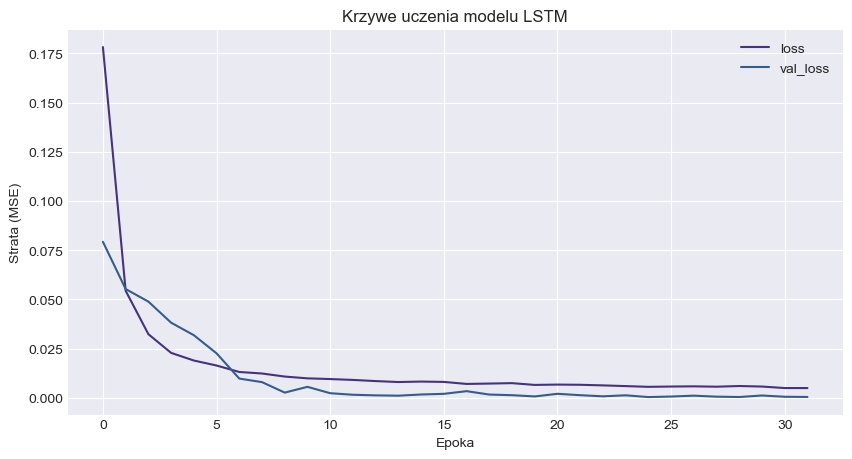

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('best_bitcoin_lstm.keras', save_best_only=True, monitor='val_loss')
    # Lub użyj tej opcji, jeśli chcesz zachować rozszerzenie .h5:
    # ModelCheckpoint('best_bitcoin_lstm.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Wizualizacja krzywych uczenia
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Krzywe uczenia modelu LSTM')
plt.xlabel('Epoka')
plt.ylabel('Strata (MSE)')
plt.legend()
plt.show()

## Ewaluacja modelu na zbiorze testowym

Oceń model na zbiorze testowym, oblicz metryki (MSE, MAE, RMSE, R2). Wyświetl wyniki i zinterpretuj je.

In [26]:
y_pred = model.predict(X_test)

# Odwrócenie skalowania
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MSE: 5015714.18
MAE: 1672.29
RMSE: 2239.58
R2: 0.9925


## Wizualizacja rzeczywistych i prognozowanych cen Bitcoina

Przekształć prognozy i rzeczywiste wartości do oryginalnej skali. Narysuj wykres porównujący rzeczywiste i prognozowane ceny na zbiorze testowym.

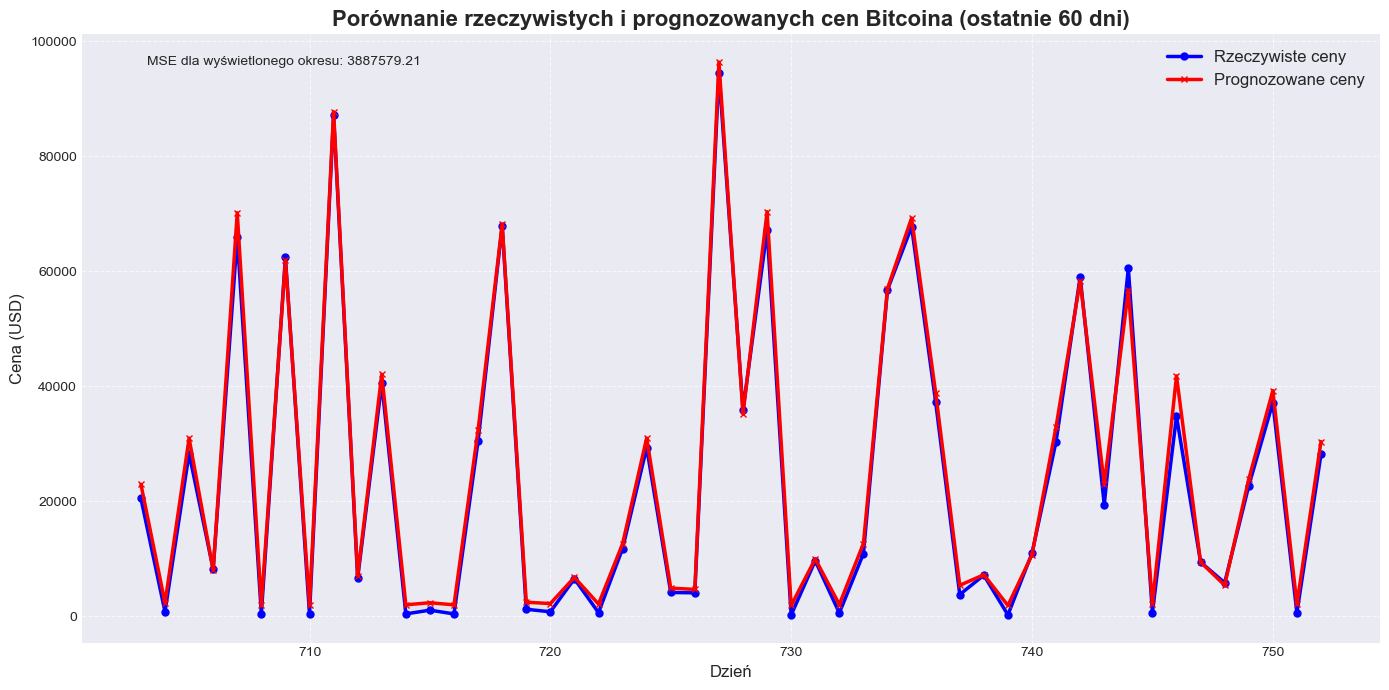

In [32]:
# Ulepszony wykres z krótszym odcinkiem czasu i wyraźniejszymi kolorami
# Pokaż tylko ostatnie 60 dni (lub inny krótszy okres)
days_to_show = 50  # możesz dostosować tę wartość
sample_indices = range(len(y_test_inv) - min(days_to_show, len(y_test_inv)), len(y_test_inv))

plt.figure(figsize=(14, 7))
plt.plot(sample_indices, y_test_inv[sample_indices], 
         'b-', linewidth=2.5, label='Rzeczywiste ceny', marker='o', markersize=5)
plt.plot(sample_indices, y_pred_inv[sample_indices], 
         'r-', linewidth=2.5, label='Prognozowane ceny', marker='x', markersize=5)

# Dodanie wypełnienia między liniami dla lepszej wizualizacji różnic
plt.fill_between(sample_indices, y_test_inv[sample_indices], y_pred_inv[sample_indices], 
                 color='lightgray', alpha=0.3)

plt.title('Porównanie rzeczywistych i prognozowanych cen Bitcoina (ostatnie 60 dni)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Dzień', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Dodanie informacji o błędzie dla pokazanego okresu
sample_mse = mean_squared_error(y_test_inv[sample_indices], y_pred_inv[sample_indices])
plt.annotate(f'MSE dla wyświetlonego okresu: {sample_mse:.2f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)

plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

## Prognoza ceny Bitcoina na najbliższy dzień

Wygeneruj prognozę ceny Bitcoina na kolejny dzień na podstawie ostatnich danych. Wyświetl prognozę na wykresie i w formie tekstowej.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\kubal\AppData\Local\Temp\ipykernel_27272\4059145995.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_prices = [float(last_days_plot[-2]), float(last_days_plot[-1])]


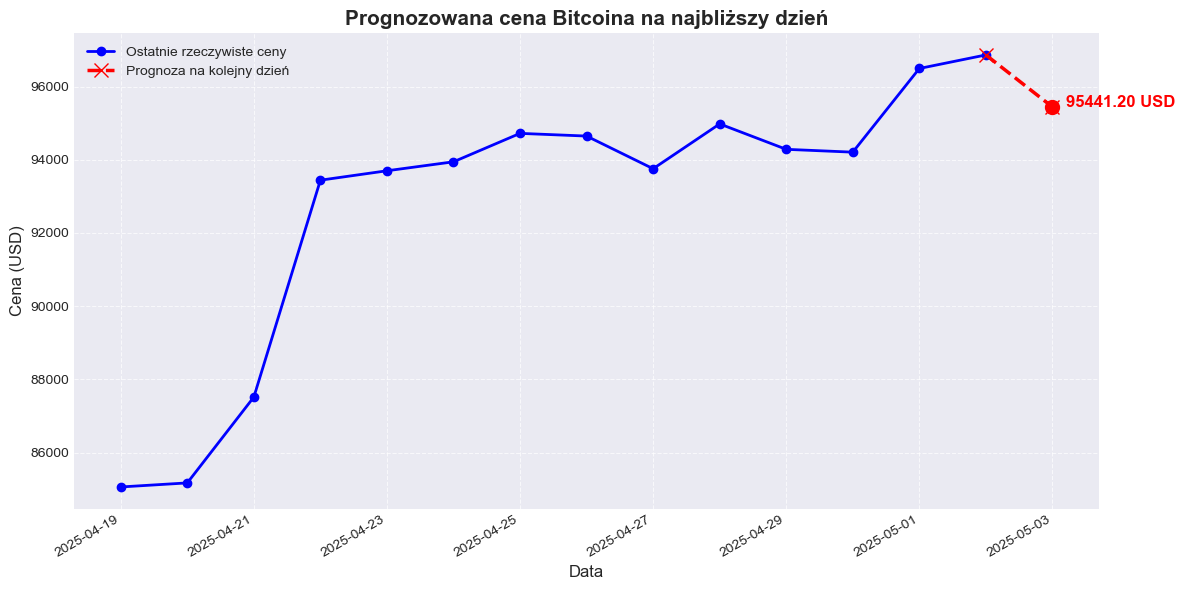

Prognozowana cena Bitcoina na najbliższy dzień: 95441.20 USD


In [36]:
# Pobieranie ostatnich danych
last_days = data['Close'].values[-window_size:]
last_days_scaled = scaler.transform(np.array(last_days).reshape(-1, 1)).flatten()
X_next = np.array(last_days_scaled).reshape(1, window_size, 1)
next_price_scaled = model.predict(X_next)[0][0]
next_price = scaler.inverse_transform([[next_price_scaled]])[0][0]

dates = data.index[-window_size:].tolist()
next_date = dates[-1] + pd.Timedelta(days=1)

# Upewniamy się, że mamy listy o odpowiednich rozmiarach
last_days_plot = list(last_days)
last_days_plot.append(next_price)
dates_plot = dates + [next_date]

# Ulepszona wizualizacja
plt.figure(figsize=(12, 6))

# Rysowanie rzeczywistych danych
plt.plot(dates_plot[:-1], last_days_plot[:-1], 'b-', marker='o', linewidth=2, 
         markersize=6, label='Ostatnie rzeczywiste ceny')

# Rysowanie prognozy - z jawną konwersją na listy
forecast_dates = [dates_plot[-2], dates_plot[-1]]
forecast_prices = [float(last_days_plot[-2]), float(last_days_plot[-1])]
plt.plot(forecast_dates, forecast_prices, 'r--', linewidth=2.5, marker='x', 
         markersize=10, label='Prognoza na kolejny dzień')

# Punkt prognozy
plt.scatter(dates_plot[-1], last_days_plot[-1], color='red', s=100, zorder=5)

# Dodanie adnotacji z prognozowaną ceną
plt.annotate(f'{next_price:.2f} USD', 
             xy=(dates_plot[-1], last_days_plot[-1]),
             xytext=(10, 0), textcoords='offset points',
             fontsize=12, fontweight='bold', color='red')

# Dodatkowe elementy wizualne dla lepszej czytelności
plt.title('Prognozowana cena Bitcoina na najbliższy dzień', fontsize=15, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Automatyczne formatowanie dat na osi x
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.legend(loc='best')
plt.show()

print(f"Prognozowana cena Bitcoina na najbliższy dzień: {next_price:.2f} USD")

Dzień 1: 2025-05-03 - Przewidywana cena: 95441 USD
Dzień 2: 2025-05-04 - Przewidywana cena: 95638 USD
Dzień 3: 2025-05-05 - Przewidywana cena: 95769 USD
Dzień 4: 2025-05-06 - Przewidywana cena: 95859 USD
Dzień 5: 2025-05-07 - Przewidywana cena: 95944 USD
Dzień 6: 2025-05-08 - Przewidywana cena: 96022 USD
Dzień 7: 2025-05-09 - Przewidywana cena: 96096 USD
Dzień 8: 2025-05-10 - Przewidywana cena: 96167 USD
Dzień 9: 2025-05-11 - Przewidywana cena: 96234 USD
Dzień 10: 2025-05-12 - Przewidywana cena: 96288 USD


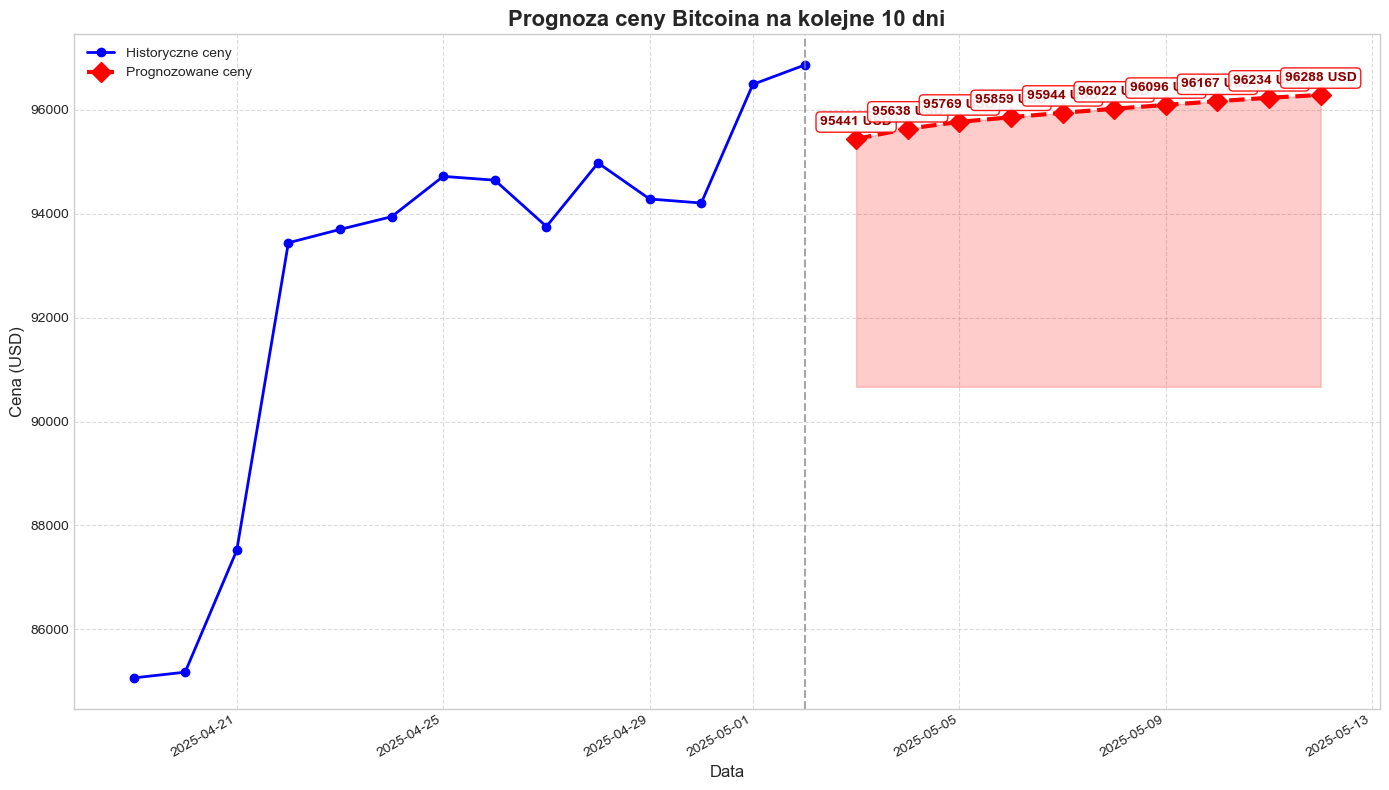


Podsumowanie prognoz na kolejne 10 dni:
Dzień 1: 2025-05-03 - 95441 USD
Dzień 2: 2025-05-04 - 95638 USD
Dzień 3: 2025-05-05 - 95769 USD
Dzień 4: 2025-05-06 - 95859 USD
Dzień 5: 2025-05-07 - 95944 USD
Dzień 6: 2025-05-08 - 96022 USD
Dzień 7: 2025-05-09 - 96096 USD
Dzień 8: 2025-05-10 - 96167 USD
Dzień 9: 2025-05-11 - 96234 USD
Dzień 10: 2025-05-12 - 96288 USD

Ostatnia realna cena: 96862 USD
Pierwsza prognozowana cena: 95441 USD
Ostatnia prognozowana cena: 96288 USD

Prognozowana zmiana po 10 dniach (od ostatniej realnej wartości): -0.59%
Procentowa zmiana między pierwszą a ostatnią prognozą: 0.89%


C:\Users\kubal\AppData\Local\Temp\ipykernel_27272\2496217685.py:87: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(data['Close'].iloc[-1])


In [46]:
# Liczba dni do prognozy
days_to_predict = 10

# Pobierz ostatnie dostępne dane
last_window = data['Close'].values[-window_size:].copy()
current_date = data.index[-1]
dates_pred = [current_date]
prices_pred = [data['Close'].values[-1]]

# Listy do przechowywania przewidywań
future_dates = []
future_prices = []

# Wykonaj predykcje rekurencyjne na kolejne dni
for i in range(days_to_predict):
    # Przygotuj dane wejściowe dla modelu
    x_input = scaler.transform(last_window.reshape(-1, 1)).flatten()
    x_input = np.array(x_input).reshape(1, window_size, 1)
    
    # Przewidywanie ceny
    price_scaled = model.predict(x_input, verbose=0)[0][0]
    predicted_price = scaler.inverse_transform([[price_scaled]])[0][0]
    
    # Dodaj nową datę i cenę
    current_date = current_date + pd.Timedelta(days=1)
    future_dates.append(current_date)
    future_prices.append(predicted_price)
    
    # Aktualizuj okno przesuwne (usuń najstarszy punkt, dodaj nową prognozę)
    last_window = np.append(last_window[1:], predicted_price)
    
    # Wyświetlanie postępu - bez groszy
    print(f"Dzień {i+1}: {current_date.date()} - Przewidywana cena: {int(predicted_price)} USD")

# Przygotuj dane do wykresu
historical_dates = data.index[-window_size:].tolist()
historical_prices = data['Close'].values[-window_size:].tolist()

# Tworzenie wykresu
plt.figure(figsize=(14, 8))

# Rysowanie danych historycznych
plt.plot(historical_dates, historical_prices, 'b-', marker='o', linewidth=2, 
         markersize=6, label='Historyczne ceny')

# Rysowanie prognoz - zwiększone rozmiary i bardziej widoczny marker
plt.plot(future_dates, future_prices, 'r--', linewidth=3, marker='D', 
         markersize=10, label='Prognozowane ceny', zorder=3)

# Dodanie wypełnienia dla lepszej wizualizacji przejścia historia->prognoza
plt.axvline(x=historical_dates[-1], color='gray', linestyle='--', alpha=0.7)
plt.fill_between(future_dates, 
                 [min(historical_prices[-1], future_prices[0])*0.95] * len(future_dates), 
                 future_prices, alpha=0.2, color='red')  # zwiększona przezroczystość

# Dodanie etykiet z cenami dla wszystkich prognoz - BEZ GROSZY
for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    # Dodajemy tło i ramkę dla etykiety, aby była bardziej widoczna
    plt.annotate(f'{int(price)} USD', 
                 xy=(date, price),
                 xytext=(0, 10),  # centrujemy nad punktem
                 textcoords='offset points',
                 fontsize=10,  # zwiększony rozmiar czcionki
                 fontweight='bold',  # pogrubienie
                 color='darkred',
                 ha='center',  # wycentrowanie poziome
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.9))

# Dodatkowe oznaczenie punktów prognoz dla lepszej widoczności
plt.scatter(future_dates, future_prices, color='red', s=80, zorder=4)

plt.title('Prognoza ceny Bitcoina na kolejne 10 dni', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Wypisanie tabeli prognoz - bez groszy
print("\nPodsumowanie prognoz na kolejne 10 dni:")
for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    print(f"Dzień {i+1}: {date.date()} - {int(price)} USD")

# Obliczanie procentowej zmiany od ostatniej realnej wartości
last_known_price = float(data['Close'].iloc[-1])
future_price_final = float(future_prices[-1])
total_change_percent = (future_price_final - last_known_price) / last_known_price * 100

# Obliczanie procentowej zmiany między pierwszą a ostatnią prognozą
first_prediction = float(future_prices[0])
last_prediction = float(future_prices[-1])
prediction_change_percent = (last_prediction - first_prediction) / first_prediction * 100

# Wyświetlanie wyników - bez groszy dla cen
print(f"\nOstatnia realna cena: {int(last_known_price)} USD")
print(f"Pierwsza prognozowana cena: {int(first_prediction)} USD")
print(f"Ostatnia prognozowana cena: {int(last_prediction)} USD")
print(f"\nPrognozowana zmiana po 10 dniach (od ostatniej realnej wartości): {total_change_percent:.2f}%")
print(f"Procentowa zmiana między pierwszą a ostatnią prognozą: {prediction_change_percent:.2f}%")

Testujemy prognozę od daty: 2022-04-12
Używamy danych historycznych z poprzednich 14 dni


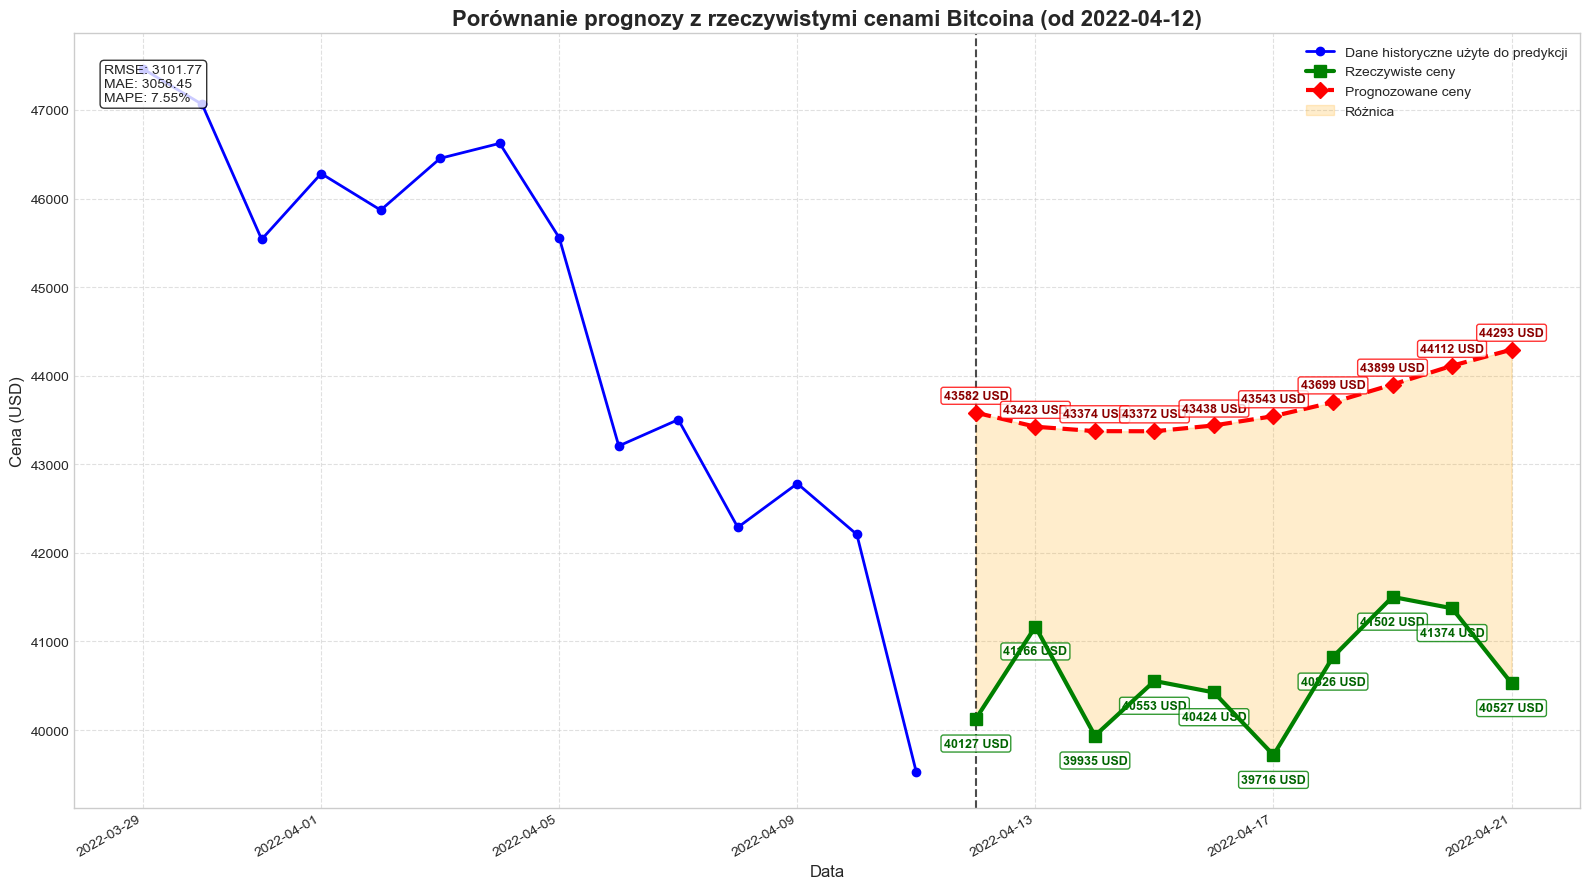


Tabela porównawcza prognoz z rzeczywistymi cenami:
Dzień 1: 2022-04-12 - Prognoza: 43582 USD, Rzeczywista: 40127 USD, Różnica: 3455 USD (8.61%)
Dzień 2: 2022-04-13 - Prognoza: 43423 USD, Rzeczywista: 41166 USD, Różnica: 2257 USD (5.48%)
Dzień 3: 2022-04-14 - Prognoza: 43374 USD, Rzeczywista: 39935 USD, Różnica: 3438 USD (8.61%)
Dzień 4: 2022-04-15 - Prognoza: 43372 USD, Rzeczywista: 40553 USD, Różnica: 2819 USD (6.95%)
Dzień 5: 2022-04-16 - Prognoza: 43438 USD, Rzeczywista: 40424 USD, Różnica: 3013 USD (7.46%)
Dzień 6: 2022-04-17 - Prognoza: 43543 USD, Rzeczywista: 39716 USD, Różnica: 3826 USD (9.63%)
Dzień 7: 2022-04-18 - Prognoza: 43699 USD, Rzeczywista: 40826 USD, Różnica: 2873 USD (7.04%)
Dzień 8: 2022-04-19 - Prognoza: 43899 USD, Rzeczywista: 41502 USD, Różnica: 2396 USD (5.78%)
Dzień 9: 2022-04-20 - Prognoza: 44112 USD, Rzeczywista: 41374 USD, Różnica: 2737 USD (6.62%)
Dzień 10: 2022-04-21 - Prognoza: 44293 USD, Rzeczywista: 40527 USD, Różnica: 3766 USD (9.29%)

Średni bezwzględ

{'mape': 7.546837914080454,
 'pred_change': 1.6329716120821232,
 'actual_change': 0.9972782828504563,
 'final_error_pct': 9.294044148980927}

In [112]:
# Testowanie modelu na losowych danych historycznych
def test_bitcoin_prediction(data, model, scaler, window_size, random_seed=None):
    """
    Testuje predykcję ceny Bitcoina na losowo wybranym okresie z przeszłości.
    
    Args:
        data: DataFrame z danymi historycznymi
        model: Wytrenowany model LSTM
        scaler: Skaler do normalizacji danych
        window_size: Rozmiar okna wejściowego dla LSTM
        random_seed: Ziarno losowości dla powtarzalności
    """
    # Ustawienie ziarna losowości
    if random_seed is not None:
        np.random.seed(random_seed)
    
    test_period = 10  # Liczba dni do prognozowania
    
    # Wybór losowego momentu z przeszłości (upewniając się, że mamy wystarczająco danych)
    min_index = window_size + 20
    max_index = len(data) - test_period - 20
    past_date_index = np.random.randint(min_index, max_index)
    past_date = data.index[past_date_index]
    
    print(f"Testujemy prognozę od daty: {past_date.date()}")
    print(f"Używamy danych historycznych z poprzednich {window_size} dni")
    
    # Pobranie danych do testów
    historical_window = data['Close'].values[past_date_index - window_size:past_date_index].copy()
    future_actual_prices = data['Close'].values[past_date_index:past_date_index + test_period]
    future_actual_dates = data.index[past_date_index:past_date_index + test_period]
    
    # Listy do przechowywania przewidywań
    test_future_dates = []
    test_future_prices = []
    current_window = historical_window.copy()
    
    # Wykonaj predykcje rekurencyjne na kolejne dni
    for i in range(test_period):
        # Przygotuj dane wejściowe dla modelu
        x_input = scaler.transform(current_window.reshape(-1, 1)).flatten()
        x_input = np.array(x_input).reshape(1, window_size, 1)
        
        # Przewidywanie ceny
        price_scaled = model.predict(x_input, verbose=0)[0][0]
        predicted_price = scaler.inverse_transform([[price_scaled]])[0][0]
        
        # Dodaj datę i cenę
        current_date = data.index[past_date_index + i]
        test_future_dates.append(current_date)
        test_future_prices.append(predicted_price)
        
        # Aktualizuj okno przesuwne (usuń najstarszy punkt, dodaj nową prognozę)
        current_window = np.append(current_window[1:], predicted_price)
    
    # Konwersja danych do jednowymiarowych tablic NumPy (to naprawia błąd fill_between)
    test_future_prices = np.array(test_future_prices).flatten()
    future_actual_prices = np.array(future_actual_prices).flatten()
    
    # Tworzenie wykresu porównawczego
    plt.figure(figsize=(16, 9))
    
    # Rysowanie danych historycznych używanych do predykcji
    historical_dates = data.index[past_date_index - window_size:past_date_index].tolist()
    historical_prices = data['Close'].values[past_date_index - window_size:past_date_index].tolist()
    plt.plot(historical_dates, historical_prices, 'b-', marker='o', linewidth=2, 
             markersize=6, label='Dane historyczne użyte do predykcji')
    
    # Rysowanie rzeczywistych cen
    plt.plot(future_actual_dates, future_actual_prices, 'g-', marker='s', linewidth=3, 
             markersize=8, label='Rzeczywiste ceny', zorder=4)
    
    # Rysowanie prognoz
    plt.plot(test_future_dates, test_future_prices, 'r--', linewidth=3, marker='D', 
             markersize=8, label='Prognozowane ceny', zorder=3)
    
    # Dodanie wypełnienia dla lepszej wizualizacji różnicy między prognozą a rzeczywistością
    plt.fill_between(test_future_dates, test_future_prices, future_actual_prices, 
                     color='orange', alpha=0.2, label='Różnica')
    
    # Dodanie etykiet z cenami dla prognoz i rzeczywistych wartości
    for i, (date, pred, actual) in enumerate(zip(test_future_dates, test_future_prices, future_actual_prices)):
        # Etykiety dla prognoz
        plt.annotate(f'{int(pred)} USD', 
                     xy=(date, pred),
                     xytext=(0, 10),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold',
                     color='darkred',
                     ha='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.8))
        
        # Etykiety dla rzeczywistych cen
        plt.annotate(f'{int(actual)} USD', 
                     xy=(date, actual),
                     xytext=(0, -20),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold',
                     color='darkgreen',
                     ha='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='green', alpha=0.8))
    
    # Dodanie pionowej linii oddzielającej dane historyczne od prognoz
    plt.axvline(x=past_date, color='black', linestyle='--', alpha=0.7)
    
    # Dodanie opisów i tytułu
    plt.title(f'Porównanie prognozy z rzeczywistymi cenami Bitcoina (od {past_date.date()})', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Cena (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gcf().autofmt_xdate()
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Obliczanie błędów prognozy
    mse = mean_squared_error(future_actual_prices, test_future_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(future_actual_prices, test_future_prices)
    
    # Obliczanie średniego procentowego błędu
    mape = np.mean(np.abs((future_actual_prices - test_future_prices) / future_actual_prices)) * 100
    
    # Dodanie informacji o błędach na wykresie
    info_text = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%'
    plt.annotate(info_text, xy=(0.02, 0.96), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round', fc='white', ec='black', alpha=0.8),
                 fontsize=10, va='top')
    
    plt.show()
    
    # Wypisanie tabeli porównawczej
    print("\nTabela porównawcza prognoz z rzeczywistymi cenami:")
    for i, (date, pred, actual) in enumerate(zip(test_future_dates, test_future_prices, future_actual_prices)):
        diff = pred - actual
        diff_percent = (diff / actual) * 100
        print(f"Dzień {i+1}: {date.date()} - Prognoza: {int(pred)} USD, Rzeczywista: {int(actual)} USD, " +
              f"Różnica: {int(diff)} USD ({diff_percent:.2f}%)")
    
    # Podsumowanie wyników
    final_diff = test_future_prices[-1] - future_actual_prices[-1]
    final_diff_percent = (final_diff / future_actual_prices[-1]) * 100
    
    pred_change = ((test_future_prices[-1] - test_future_prices[0]) / test_future_prices[0] * 100)
    actual_change = ((future_actual_prices[-1] - future_actual_prices[0]) / future_actual_prices[0] * 100)
    
    print(f"\nŚredni bezwzględny błąd procentowy (MAPE): {mape:.2f}%")
    print(f"Prognozowana zmiana po 10 dniach: {pred_change:.2f}%")
    print(f"Rzeczywista zmiana po 10 dniach: {actual_change:.2f}%")
    print(f"Błąd prognozy na 10. dzień: {final_diff_percent:.2f}%")
    
    return {
        'mape': mape,
        'pred_change': pred_change,
        'actual_change': actual_change,
        'final_error_pct': final_diff_percent
    }

# Uruchom test z losowym ziarnem dla powtarzalności
test_bitcoin_prediction(data, model, scaler, window_size)